# 10.1 Attention Cues

In [1]:
import torch
from d2l import torch as d2l
import math

In [3]:
torch.cuda.is_available()

True

In [4]:
def show_heatmap(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """
    Show heatmaps of matrices.
    
    :param matrices: 4-d array (num_rows{图像个数}, num_cols, fig_height{图像大小}, fig_width)
    """
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

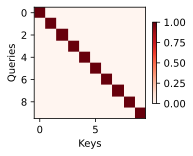

In [5]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmap(attention_weights, xlabel='Keys', ylabel='Queries')

In [6]:
def show_heatmap(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """
    Show heatmaps of matrices.
    
    :param matrices: 4-d array (num_rows{图像个数}, num_cols, fig_height{图像大小}, fig_width)
    """
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

# 10.2 Attention Pooling 

### 10.2.1 Generating the Dataset

In [7]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np

In [8]:
def f(x):
    return 2 * torch.sin(x) + x ** 0.8

In [9]:
n_train = 50 # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5) # Training inputs
# (0, 1) => (0, 5)

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, ))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)

### 10.2.2 Average Pooling 

In [10]:
def plot_kernel_reg(y_hat):
    """
    fig是axes的容器，axes才是一个可以绘制的图像
    """
    fig, ax = d2l.plt.subplots()
    ax.plot(x_test, y_truth, label="Truth")
    ax.plot(x_test, y_hat, label="Predicted")
    ax.plot(x_train, y_train, 'o', label="Train") # label here is used for ax.legned()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.legend() # display legend 
    ax.grid() # display grid
    # 最后是坐标轴的细节
    ax.xaxis.set_ticks(np.arange(0, 5, 0.5))
    ax.yaxis.set_ticks(np.arange(0, 5, 0.5))

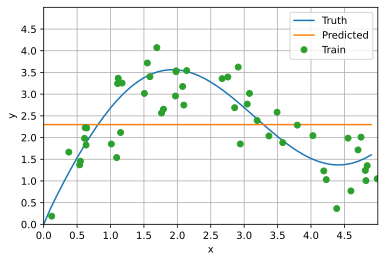

In [11]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 10.2.3 Nonparametric Attention Pooling 

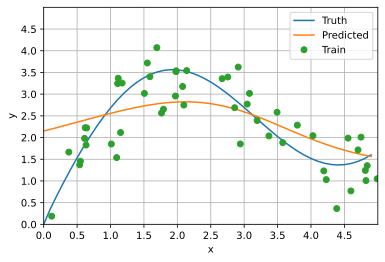

In [12]:
X_repeated = x_test.repeat_interleave(n_train).reshape((-1, n_train))
"""
repeat_interleave(num, dim=0): 将x_test在dim上重复num次
"""
attention_weights = nn.functional.softmax(-(X_repeated - x_train)**2/2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

'\nunsqueeze在这里是为了升维，其中第一个参数是在第几维上升维\n'

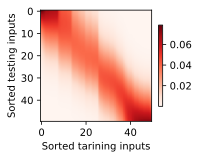

In [13]:
show_heatmap(attention_weights.unsqueeze(0).unsqueeze(0), xlabel="Sorted tarining inputs", ylabel="Sorted testing inputs") 
"""
unsqueeze在这里是为了升维，其中第一个参数是在第几维上升维
"""

### 10.2.4 Parametric Attention Pooling

In [14]:
"""
(b, x, y, z...); 其中第一维是batch_size
"""
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
"""
bmm会忽略batch的维度进行矩阵乘法
"""
torch.bmm(X, Y).shape 

torch.Size([2, 1, 6])

In [15]:
"""
weights.unsqueeze(1) => (2, 1, 10)
values.unsqueeze(-1) => (2, 10, 1) 
因此结果shape为(2, 1,  1)
"""
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

**Define the Model**

In [16]:
class NWKernelRegression(nn.Module):
    """
    在使用batch based操作时，牢记所有对象的维度从1开始
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape(-1, keys.shape[1])
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w) ** 2 / 2, dim=1)
        """
        1. 这里attention_weights.unsqueeze(1)是为了将attention_weights升到2维矩阵, 升后为 1 x n
        values升后为n x 1， 从而 1 x n x n x 1 = 1
        得到1 x 1 的attention_score
        2. 因为torch.dot不会忽略batch dim, 因此只能用bmm曲线救国
        3. reshape(-1) => (1, ) 变为1维的array
        """
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1) 

**Training**

In [17]:
"""
repeat(n_train, dim) # 在dim上重复x_train n_train次，注意和repeat_interleave的区别，repeat会升维
"""
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

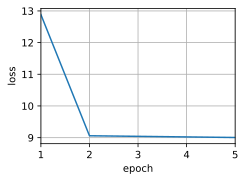

In [18]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch+1}, loss {float(l.sum()):.6f}')
    animator.add(epoch+1, float(l.sum()))

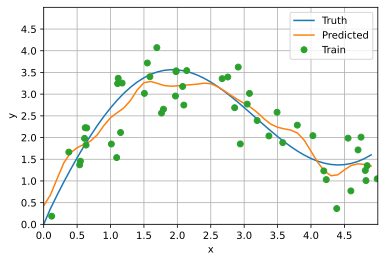

In [19]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

In [20]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import math

In [21]:
def show_heatmap(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """
    Show heatmaps of matrices.
    
    :param matrices: 4-d array (num_rows{图像个数}, num_cols, fig_height{图像大小}, fig_width)
    """
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

## 10.3 Attention Scoring Functions 

### 10.3.1 Masked Softmax Operation

As we just mentioned, a softmax operation is used to output a probability distribution as attention weights. In some cases, not all the values should be fed into attention pooling. For instance, some text sequences are padded with special tokens that do not carry meaning. To get an attention pooling over only meaningful tokens as values, we can specify a valid sequence length to filter out those beyond this specified range when computing softmax. In this way, we can implement such a *masked softmax operation* in the follwing *masked_softmax* function, where any value beyond the valid length is masked as zero

后文中的valid_lens都一样，只在softmax计算attention score时起作用

被masked部分attention score为0 

In [22]:
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [23]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4020, 0.5980, 0.0000, 0.0000],
         [0.4259, 0.5741, 0.0000, 0.0000]],

        [[0.3468, 0.3406, 0.3126, 0.0000],
         [0.3561, 0.2977, 0.3462, 0.0000]]])

In [24]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3195, 0.3685, 0.3120, 0.0000]],

        [[0.6445, 0.3555, 0.0000, 0.0000],
         [0.1710, 0.3275, 0.3211, 0.1803]]])

### 10.3.2 Additive Attention

Additive Attention不要求keys的维度与query对应

$$
\alpha(Q, K) = w_v^Ttanh(QW_q + KW_k) \in R^{mxn} \newline
W_q \in R^{qxh} \newline 
W_k \in R^{kxh} \newline 
w_v \in R^h \newline 
\text{m is the number of queries} \newline 
\text{n is the number of key-value pairs} \newline
$$

In [25]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # dimensionm expansion
        """
        注意这里的升维，算是一个小技巧
        """
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [26]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)

In [27]:
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

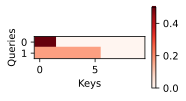

In [28]:
show_heatmap(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries")

### 10.3.3 Scaled Dot-Product Attention
$$
\alpha(q, k) = \frac{q^Tk}{\sqrt{d}} \newline
\alpha(Q, K) = \frac{Q^TK}{\sqrt{d}} \newline 
Q = [q_1^T, q_2^T ... q_n^T], \text{q is row-vector} \newline
K = [k_1, k_2, k_3, ..., k_n]^T, \text{k is row-vector}
$$

In [29]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)/math.sqrt(d))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [30]:
queries, keys = torch.normal(0, 1, (2, 1, 2)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

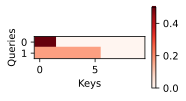

In [31]:
show_heatmap(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

## 10.4 Bahdanau Attention

## 10.5 Muti-Head Attention

$$
h_i = f(W_i^qq, W_i^kk, W_i^vv) \in R^{p_v} \newline 
h: \text{number of heads} \newline 
d_k: \text{number of keys} \newline 
p_k: \text{dim of key} \newline
$$
为了实现并行计算，我们有如下假设
$$
hp_q = hp_k = hp_v = p_o \newline
W^q = [W_1^q, W_2^q, W_3^q,...,W_h^q]
$$

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    
    def forward(self, queries, keys, values, valid_lens):
        """
        Shape of `queries`, `keys`, `values`:
        (batch_size, no. of queries or key-value pairs, num_hiddens)
        Shape of `valid_lens`
        (batch_size, .)
        """
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [33]:
def transpose_qkv(X, num_heads):
    # Shape of input `X`:
    # (batch_size, no. of queries or key-value pairs, num_hiddens)
    # Shape of output `X`:
    # (batch_size, no. of queries or key_value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # Shape of output `X`:
    # (batch_size, num_heads, no. of queries or key_value pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output `X`:
    # (batch_size * num_heads, no. of queries or key_value pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """
    Reverse the operation of transpose_qkv
    """
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [34]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [35]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

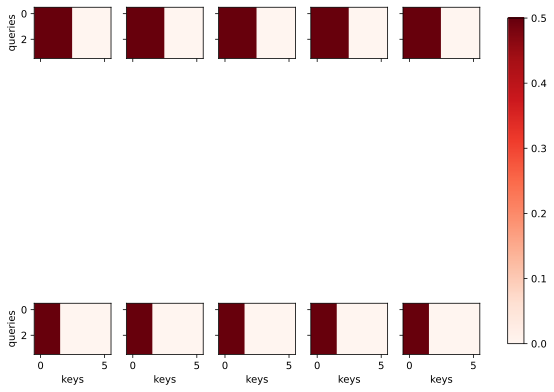

In [36]:
show_heatmap(attention.attention.attention_weights.reshape((2, 5, 4, 6)), 'keys', 'queries', figsize=(10, 10))

## 10.6 Self-Attention and Positional Encoding 

In deep learning, we often use CNNs or RNNs to encode a sequence. Now with attention mechanisms, imagine that we feed a sequence of tokens into attention pooling so that the same set of tokens act as queries, keys and values. 

Since the queries, keys, and values come from the same place, this performs self-attention, which is also called intro-attention

自注意力机制本质上和注意力其实已经没有太大关系，它在deep learning中只是作为一种和CNNs以及RNNs类似的用于表示学习的结构存在，并且相对于CNNs和RNNs具有自己的特点

you produce a weighed combination of your entire neighborhood, that's what attention does.

$$
y_i = f(x_i, (x_1, x_1), ..., (x_n, x_n)) \in R^d
$$

## 10.6.1 Self-Attention

In [37]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [58]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

### 10.6.2 Comparing CNNs, RNNs, and Self-Attention

**并无严格理论证明的解释**

CNNs的缺点在于无法学习到长距离依赖信息，对于长距离依赖需要叠加多层

RNNs的缺点在于无法并行运算

Self-Attention就刚好弥补了中间的缺陷，一方面可以学习到长距离依赖信息，另一方面可以轻松进行并行运算
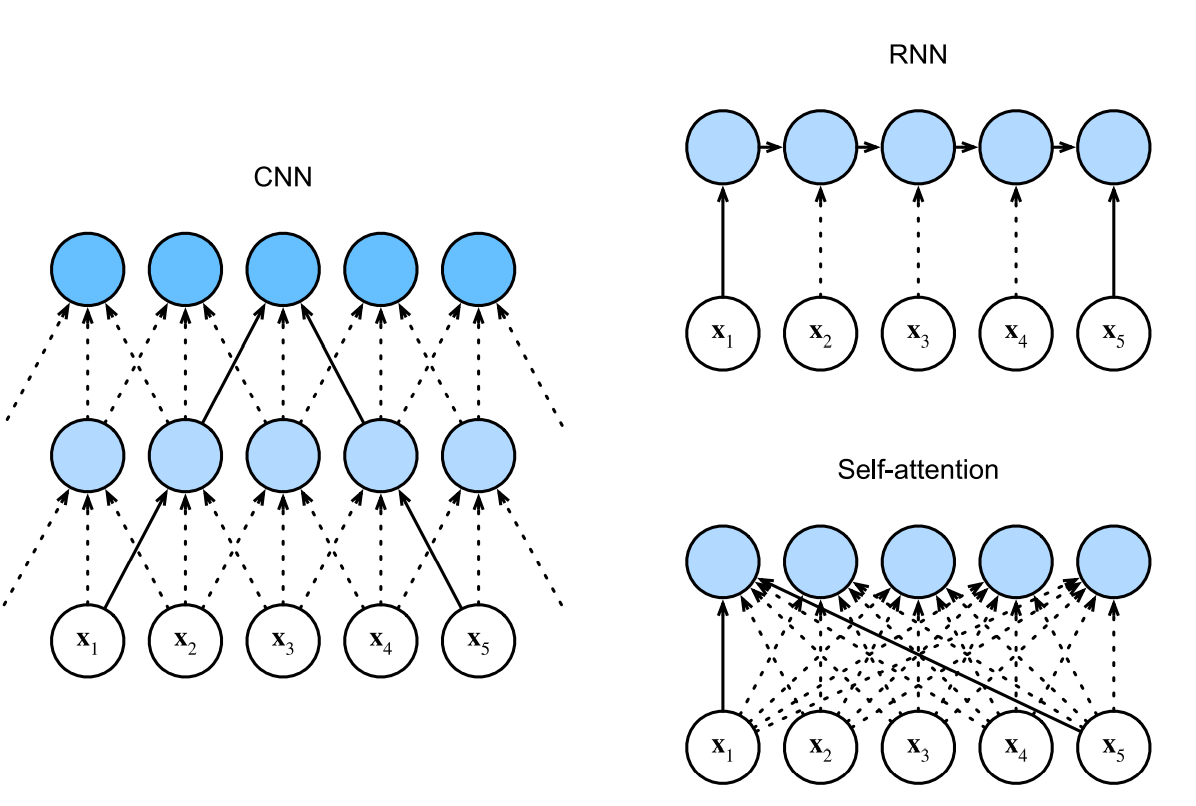
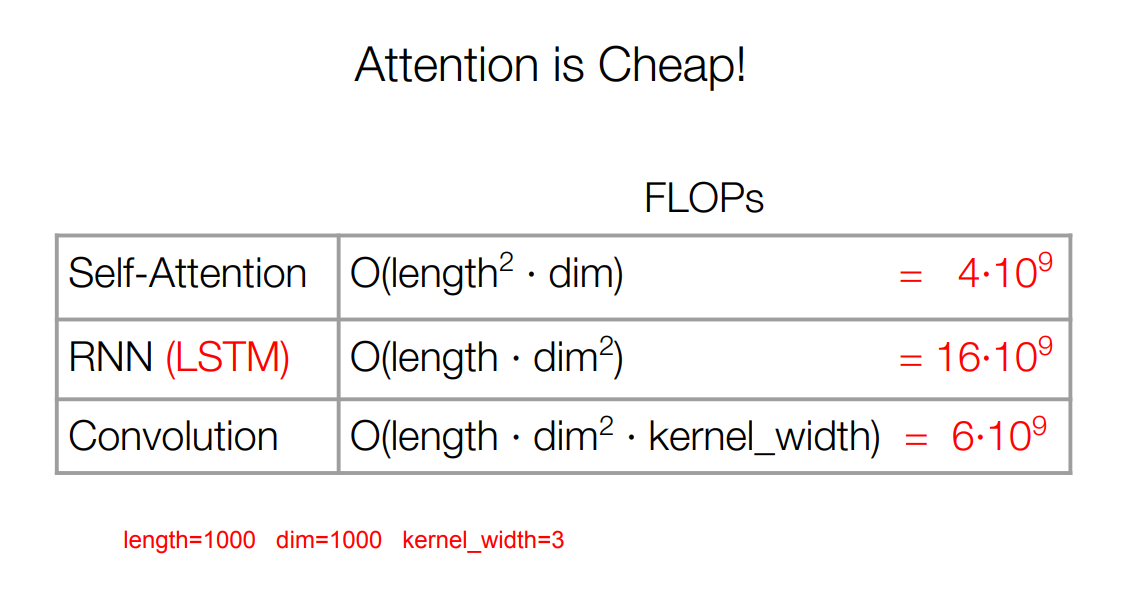

Self-Attention的时间复杂度推导：
$$
y = \frac{QK^T}{\sqrt{d}} \newline
Q = [q1^T, q2^T, ...]; \text{$q_i$ is row vector} \newline
Q \in R^{p_qxd_q} \newline 
K \in R^{p_kxd_k}
$$
$p_k=p_q$为number of queries/keys, $d_q=d_k$为dim of queries/keys，因此复杂度为$n^2d$


当sequence特别长的时候，Self-Attention就会比较慢

### 10.6.3 Positional Encoding

怎么样去做Positional Encoding？
要表示位置信息，首先出现在脑海里的一个点子可能是，给句子中的每个词赋予一个相位，也就是[0, 1]中间的一个值，第一个词是0，最后一个词是1，中间的词在0到1之间取值。

这是个符合直觉的想法，但是这样会不会有什么问题呢？

其中一个问题在于，你并不知道每个句子中词语的个数是多少，这会导致每个词语之间的间隔变化是不一致的。而对于一个句子来说，每个词语之间的间隔都应该是具有相同含义的。

那，为了保证每个词语的间隔含义一致，我们是不是可以给每个词语添加一个线性增长的时间戳呢？比如说第一个词是0，第二词是1，以此类推，第N个词的位置编码是N。

这样其实也会有问题。同样，我们并不知道一个句子的长度，如果训练的句子很长的话，这样的编码是不合适的。 另外，这样训练出来的模型，在泛化性上是有一定问题的。

因此，理想状态下，编码方式应该要满足以下几个条件，

1. 对于每个位置的词语，它都能提供一个独一无二的编码
2. 词语之间的间隔对于不同长度的句子来说，含义应该是一致的
3. 能够随意延伸到任意长度的句子


To use the sequence order information, we can inject absolute or relative positional information by adding *positional encoding* to the input representations. Positional encodings can be either learned or fixed.

$$
p_{i, 2j} = sin(\frac{i}{10000^{2j/d}}) \newline
p_{i, 2j+1} = cos(\frac{i}{10000^{2j/d}})
$$

Positional Encoding为序列中每个位置赋予了唯一的浮点数编码

为什么这样简单的sines和cosines的组合可以表达位置信息呢？

一开始的确有点难理解。别着急，这边举个二进制的例子就明白了。可以观察一下下面这个表，我们将数字用二进制表示出来。可以发现，每个比特位的变化率是不一样的，越低位的变化越快，红色位置0和1每个数字会变化一次，而黄色位，每8个数字才会变化一次。
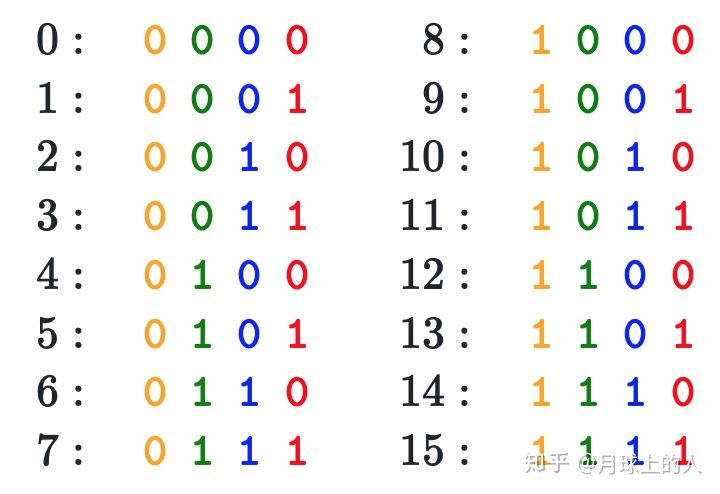

不同频率的sines和cosines组合其实也是同样的道理，通过调整三角函数的频率，我们可以实现这种低位到高位的变化，这样的话，位置信息就表示出来了。

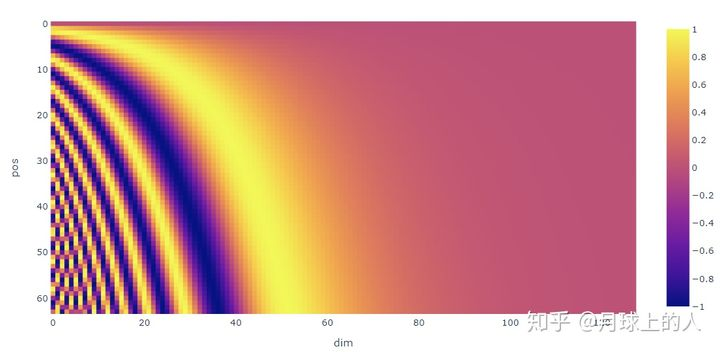
128维位置编码2D示意图

有点类似于将[0, 1]离散空间映射到低维稠密空间

In [82]:
class PositionalEncoding(nn.Module):
    """Positional Encoding"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # create a long enough P
        self.P = torch.ones((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
        10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [83]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim))) # Shape (1, num_steps, encoding_dim)
P = pos_encoding.P[:, :X.shape[1], :] # Shape (1, num_steps, encoding_dim)

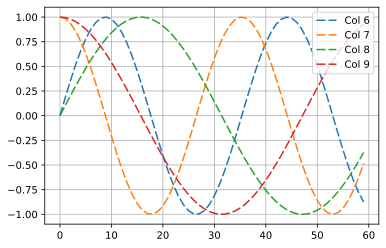

In [84]:
fig, ax = d2l.plt.subplots()
for i in range(6, 10):
    ax.plot(torch.arange(num_steps), P[0, :, i], dashes=[6, 2], label="Col %d" % i)
ax.grid()
ax.legend(loc="upper right")

**Absolute Positional Information**

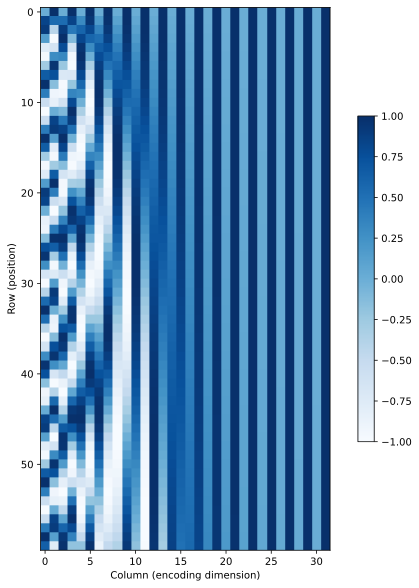

In [85]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
show_heatmap(P, xlabel="Column (encoding dimension)", ylabel="Row (position)", figsize=(10, 10), cmap="Blues")

可以看到左边低位变化频率就很快，但是右边高位基本就不怎么变化了

## 10.7 Transformer

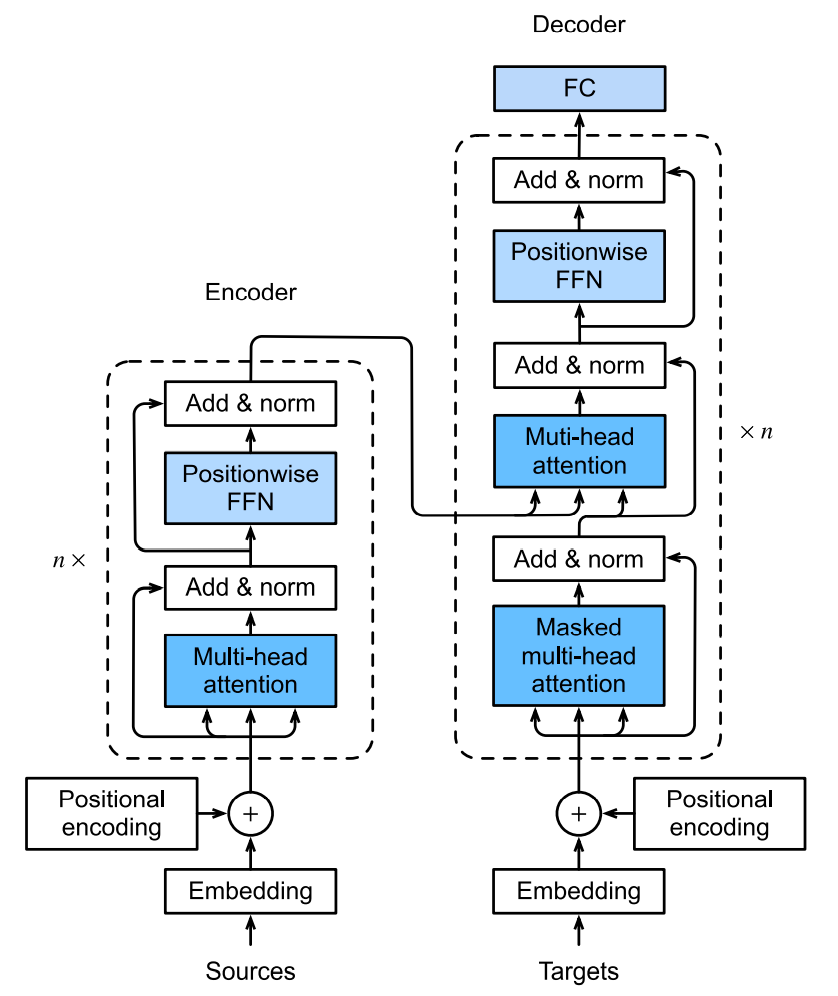

In [86]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### 10.7.2 PositionWise Feed-Forward Networks

The positionwise feed-forward network transforms the representation at all the sequence positions using the same MLP.

假设输入为$R^{nxd}$，则Positionwise FFN会对n个d维向量，都执行相同的的操作（共用FFN layer)，即FFN被n个d维向量共享

In [90]:
class PositionWiseFFN(nn.Module):
    """Positional feed-forward network"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [93]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0] # Shape (batch_size, num_keys, dim_keys)

tensor([[ 0.4555, -0.9495, -0.2171,  0.1551,  0.1776,  0.5580,  0.0195,  0.1074],
        [ 0.4555, -0.9495, -0.2171,  0.1551,  0.1776,  0.5580,  0.0195,  0.1074],
        [ 0.4555, -0.9495, -0.2171,  0.1551,  0.1776,  0.5580,  0.0195,  0.1074]],
       grad_fn=<SelectBackward>)

### 10.7.3 Residual Connection and Layer Normalization

In [94]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print ('layer norm: ', ln(X), '\nbatch norm: ', bn(X))

layer norm:  tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm:  tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


In [97]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

值得注意的下面代码常用于debug模型的正确性

torch.ones((2, 3, 4)) $\in R^{2x3x4}$

一般通过shape来判断结果是否正确，对于更细致的细节就很难验证了

In [98]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

### 10.7.4 Encoder